In [1]:
%config Completer.use_jedi = False

In [139]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import geoplot as gplt
import geopandas as gpd
import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver

from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.utils import *
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "UK25_3"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

# #UK = gpd.read_file("../datasets/united_kingdom_european_regions/Regions__December_2019__Boundaries_EN_BFC-shp/Regions__December_2019__Boundaries_EN_BFC.shp")
# dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
# dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
# #distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

mutation_arange = [np.round(x,2) for x in np.arange(0.1,1,0.2)]

In [78]:
from ast import literal_eval
def plot_parameter_comparison(dataframe,column_name,y_lim=None,population_size=None):
    plot_curves = []
    plot_labels = []
    for parameter_group in dataframe["Parameter Group"].unique():    
      
        parameter_group_df = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
        parameter_group_data_column = parameter_group_df[column_name]
        if type(parameter_group_data_column.iloc[0]) == str:
            parameter_group_curves = np.stack(parameter_group_data_column.apply(literal_eval).to_numpy())
        else:
            parameter_group_curves = np.stack(parameter_group_data_column.to_numpy())
   
        parameter_group_curves_mean = np.mean(parameter_group_curves,axis=0)
        plot_curves.append(parameter_group_curves_mean)
        plot_labels.append(int(parameter_group))
    
    plot_conv_curves(np.array(plot_curves),plot_labels,y_lim=y_lim)
    


def get_population_size_splits(dataframe,population_sizes=[10,20,30]):
    df_copy = deepcopy(dataframe)
    df_params = pd.DataFrame(df_copy.Parameters.apply(literal_eval).apply(dict).apply(pd.Series))
    population_sizes_dfs = []
    
    for column in df_params.columns:
        df_copy[column] = df_params[column]
    
    for population_size in population_sizes:
        
        df_pop_size = df_copy.where((df_copy.population_size == population_size) & (df_copy.mutation.isin(mutation_arange))).dropna()
        population_sizes_dfs.append(df_pop_size)
    return population_sizes_dfs


def expand_parameter_colums(dataframe):
    df_params = pd.DataFrame(dataframe.Parameters.apply(literal_eval).apply(dict).apply(pd.Series))
    for column in df_params.columns:
        dataframe[column] = df_params[column]

def add_final_fitness_columns(dataframe):
    if not "fuel_consumption_final" in dataframe.columns:
        if type(dataframe.fuel_consumption.iloc[0]) == str:
            dataframe.fuel_consumption = dataframe.fuel_consumption.apply(literal_eval)
        

        dataframe["fuel_consumption_final"] = [dataframe.fuel_consumption.loc[i][-1] for i in list(dataframe.index)]

    
    if not "longest_route_time_final" in dataframe.columns:
        if type(dataframe.vehicle_route_time.iloc[0]) == str:
            dataframe.vehicle_route_time = dataframe.vehicle_route_time.apply(literal_eval)
        dataframe["longest_route_time_final"] = [np.max(dataframe.vehicle_route_time.loc[i])/60 for i in list(dataframe.index)]
    
    
def remove_unwanted_mutation_parameter_groups(dataframe,mutation_range=mutation_arange):
    df_params = pd.DataFrame(dataframe.Parameters.apply(literal_eval).apply(dict).apply(pd.Series))
    dataframe = dataframe.where(df_params.mutation.isin(mutation_range)).dropna()
    return dataframe

In [79]:

def plot_drive_time_distribution(data, start_nodes, bar_kwargs={"SA":{"color":"#1f77b4"}, "NSGA-II": {"color":"#ff7f0e"}, "NSGAIII":{"color":"#2ca02c"}, "IBEA":{"color":"#d62728"}, "IBEA-Adaptive":{"color":"#9467bd"}, "LS":{"color":"#8c564b"}, "GA":{"color":"#e377c2"}}):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    num_bars = len(data)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
        
    for algorithm_name, offset in zip(data, offsets):
        ax.bar(np.array(range(0,len(data[algorithm_name]["vehicle_drive_times"][0].keys())))+offset, np.mean(data[algorithm_name]["drive_times_list"],axis=0), width=0.2,alpha=0.8,label=r"$\bf{%s}$" % (algorithm_name),align="center")
        plt.xticks(range(0,len(start_nodes)),labels=range(0,len(start_nodes)))
    
    
    
    plt.legend(bbox_to_anchor=(1,1))
    
    return fig, ax

In [80]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

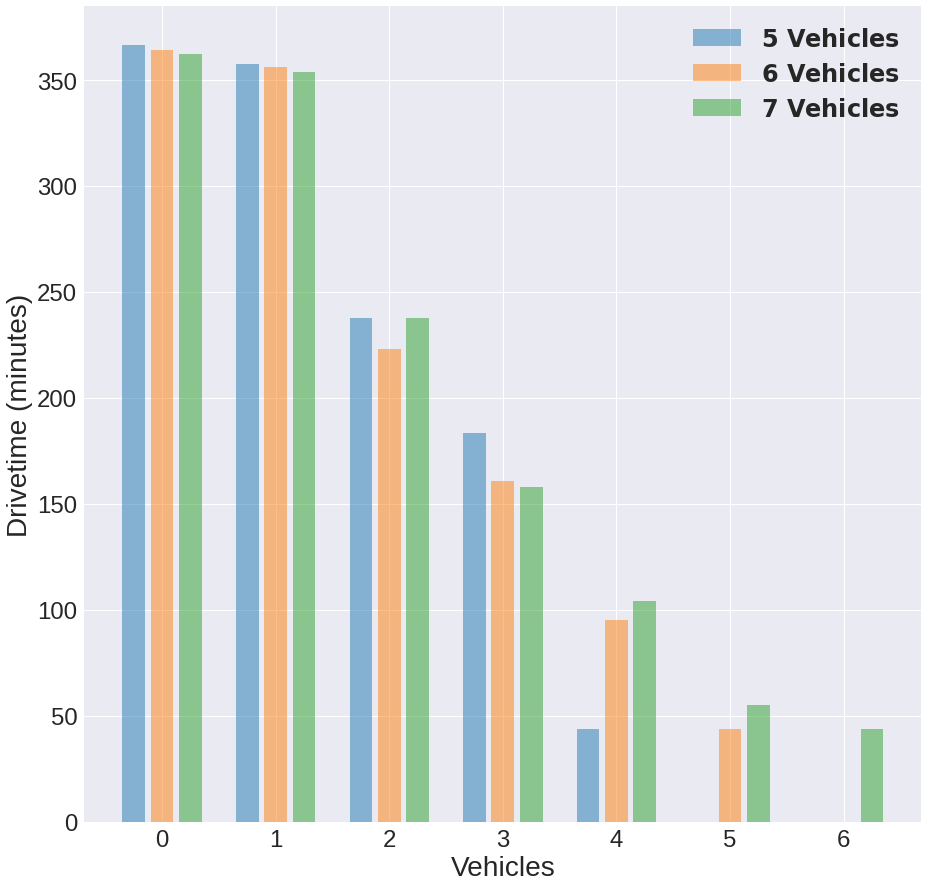

In [116]:
plot_vehicle_drivetimes(SA_data,3)

In [82]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def anova_plot(data,variable_field,between_fields,path=None,save=False):
    fig,ax = plt.subplots(1,1,figsize=(15,15))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    tukey.plot_simultaneous(figsize=(15,15),ax=ax)
    ax.set_xlabel(variable_field,fontsize=24)
    ax.set_ylabel("Parameter Group",fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.title("")
    plt.show()
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df.where(summary_df.reject == True,inplace=True)
    summary_df.dropna(inplace=True)
    return summary_df ,fig, tukey
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov
def extractOptimalParameters(resultsDataFrame,tukeyResult,amount=5):
    optimalParamGroups = tukeyResult.sort_values(by='meandiff').head(amount).group2
    resultDF = pd.DataFrame(columns=resultsDataFrame.columns)
    for group in optimalParamGroups:
        resultDF = pd.concat([resultDF,(resultsDataFrame.where(resultsDataFrame.paramGroup == np.float(group))).dropna()],axis=0)
    return resultDF


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning:

FixedFormatter should only be used together with FixedLocator



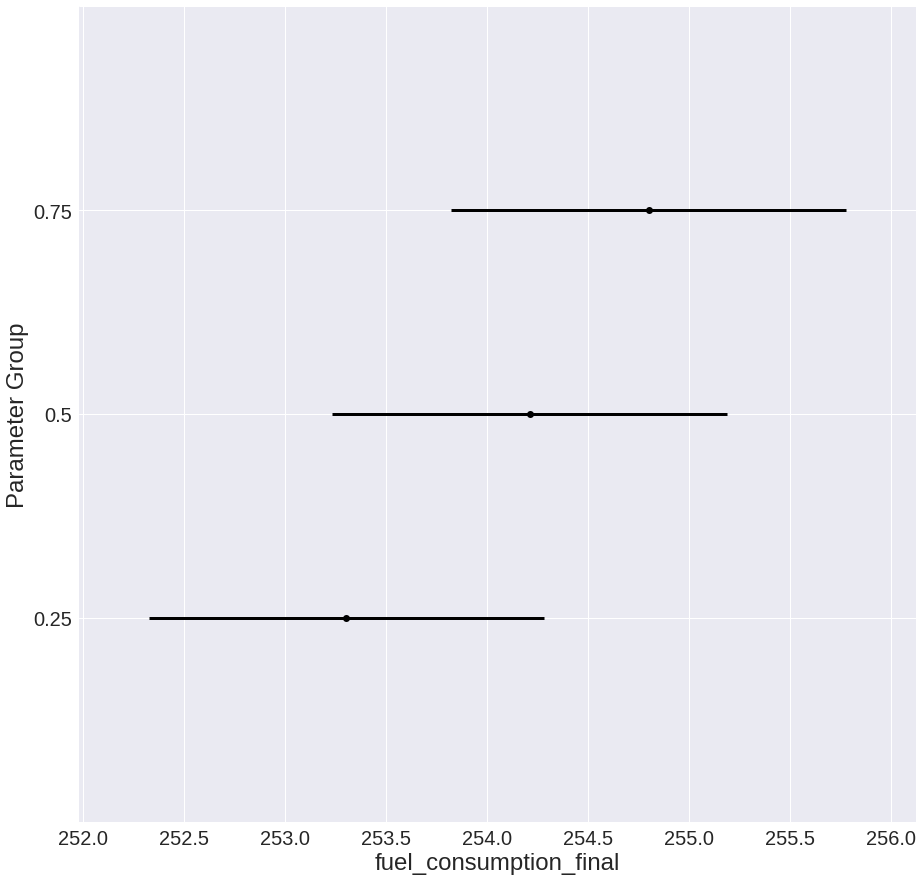

In [162]:
sa_data_tukey,fig,t = anova_plot(UNSGA3_data,'fuel_consumption_final','crossover')
#sa_data_optimal = extractOptimalParameters(sa_data,sa_data_tukey,1)


In [83]:
SA_data = pd.read_csv("parameter_data/{}/SA.csv".format(dataset))
GA_data = pd.read_csv("parameter_data/{}/GA.csv".format(dataset))
NSGA2_data = pd.read_csv("parameter_data/{}/NSGA2.csv".format(dataset))
NSGA3_data = pd.read_csv("parameter_data/{}/NSGA3.csv".format(dataset))
UNSGA3_data = pd.read_csv("parameter_data/{}/UNSGA3.csv".format(dataset))
#IBEA_data = pd.read_csv("parameter_data/{}/IBEA.csv".format(dataset))


# SA

In [84]:
SA_data = remove_unwanted_mutation_parameter_groups(SA_data)
add_final_fitness_columns(SA_data)
expand_parameter_colums(SA_data)

In [85]:
SA_optimal_params = SA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
SA_optimal_params

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation
Parameter Group,,,,
3.0,14.5,244.868543,364.809444,0.7


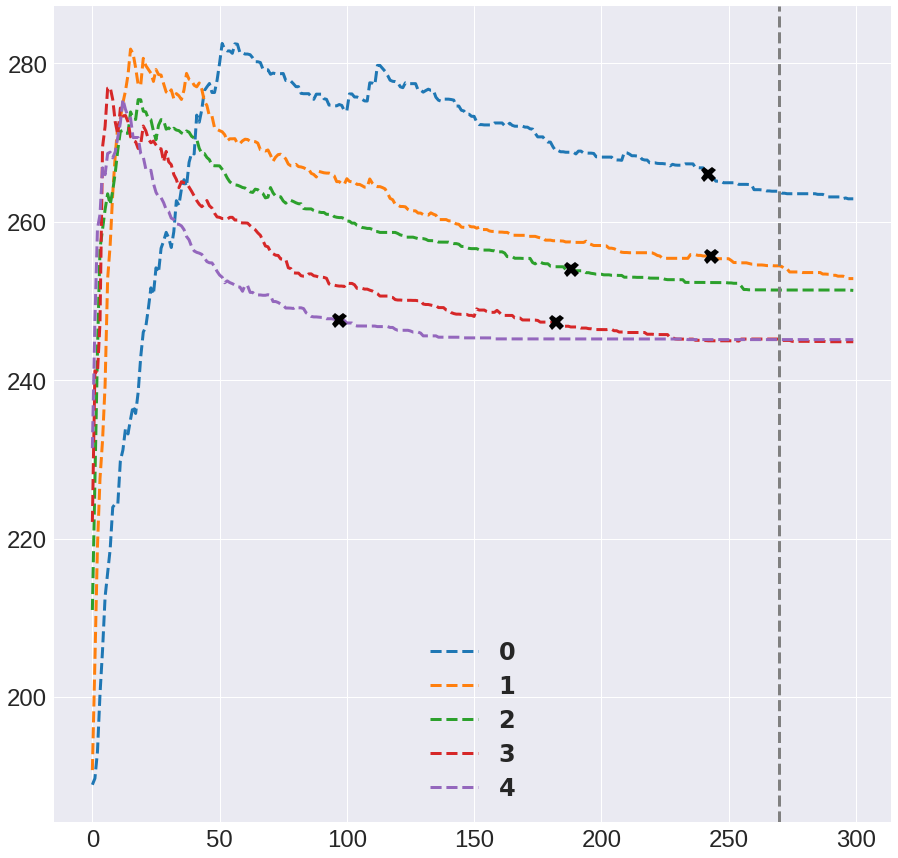

In [86]:
plot_parameter_comparison(SA_data,"fuel_consumption")

# GA

In [87]:
GA_data = remove_unwanted_mutation_parameter_groups(GA_data)
add_final_fitness_columns(GA_data)
expand_parameter_colums(GA_data)
GA_data_10pop, GA_data_20pop, GA_data_30pop = get_population_size_splits(GA_data)

In [88]:
GA_optimal_params = GA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
GA_optimal_params

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
37.0,14.5,244.499552,367.076111,0.9,0.25,20.0


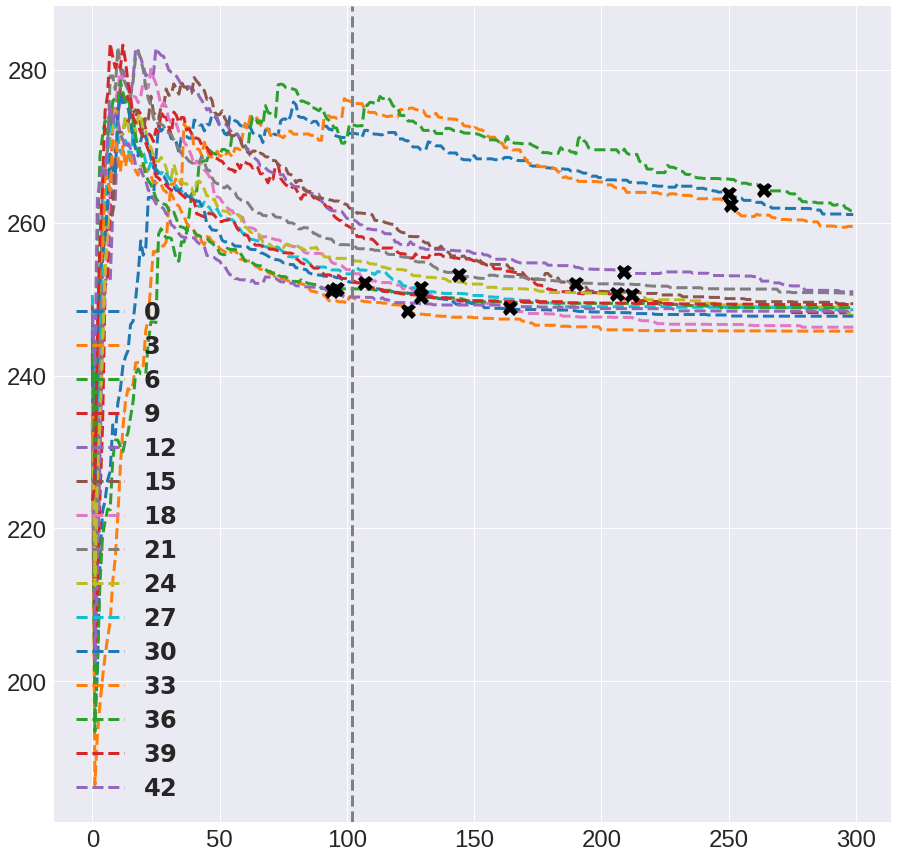

In [89]:
plot_parameter_comparison(GA_data_10pop,"fuel_consumption")

# NSGA-II

In [90]:
NSGA2_data = remove_unwanted_mutation_parameter_groups(NSGA2_data)
add_final_fitness_columns(NSGA2_data)
expand_parameter_colums(NSGA2_data)
NSGA2_data_10pop, NSGA2_data_20pop, NSGA2_data_30pop = get_population_size_splits(NSGA2_data)

In [91]:
NSGA2_optimal_params = NSGA2_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
NSGA2_optimal_params

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
25.0,14.5,242.877012,382.472222,0.5,0.75,20.0


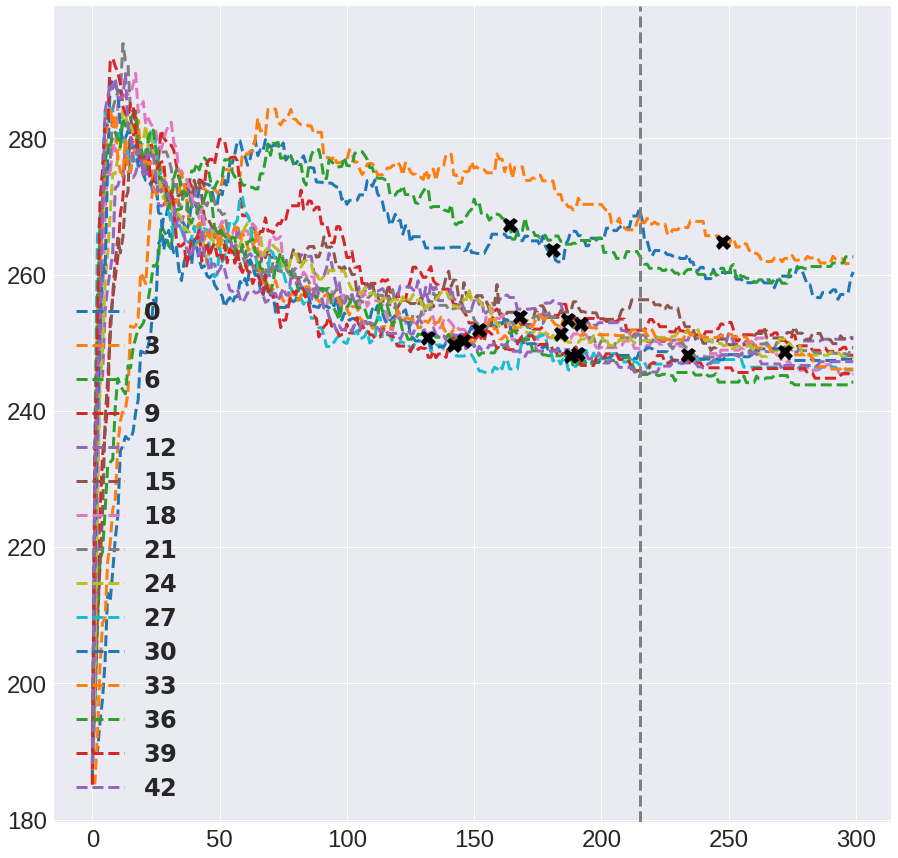

In [92]:
plot_parameter_comparison(NSGA2_data_10pop,"fuel_consumption")

# NSGA-III

In [93]:
NSGA3_data = remove_unwanted_mutation_parameter_groups(NSGA3_data)
add_final_fitness_columns(NSGA3_data)
expand_parameter_colums(NSGA3_data)
NSGA3_data_10pop, NSGA3_data_20pop, NSGA3_data_30pop = get_population_size_splits(NSGA3_data)

In [94]:
NSGA3_optimal_params = NSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
NSGA3_optimal_params

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
37.0,14.5,246.33221,377.816111,0.9,0.25,20.0


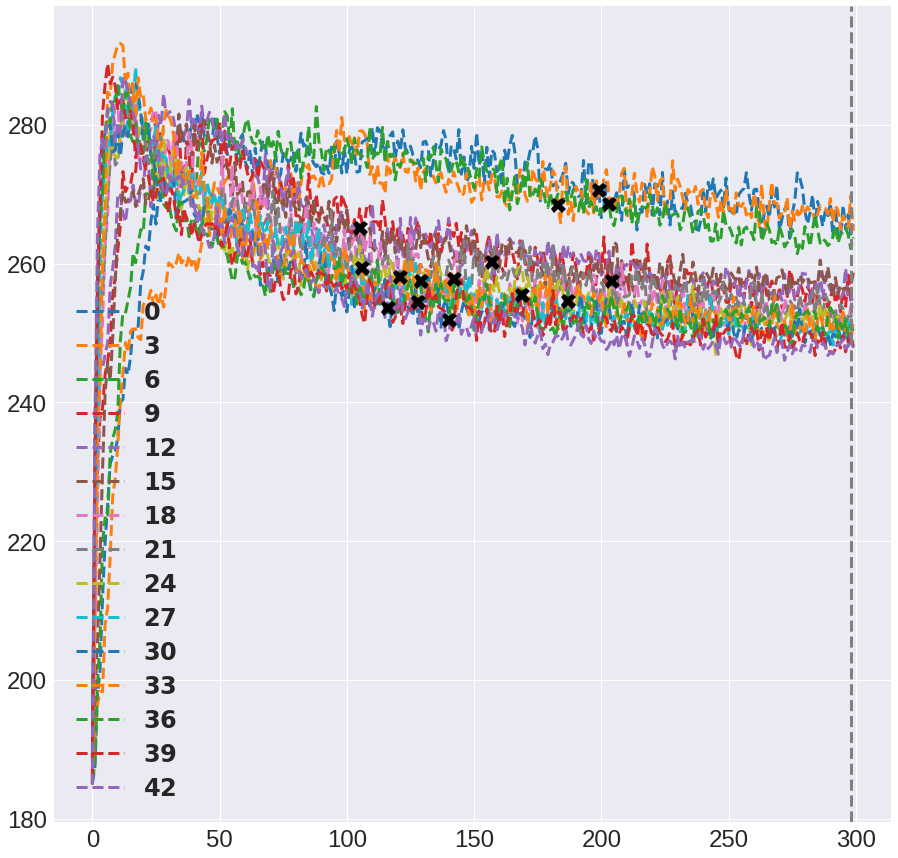

In [98]:
plot_parameter_comparison(NSGA3_data_10pop,"fuel_consumption")

# UNSGA-III

In [99]:
UNSGA3_data = remove_unwanted_mutation_parameter_groups(UNSGA3_data)
add_final_fitness_columns(UNSGA3_data)
expand_parameter_colums(UNSGA3_data)
UNSGAIII_data_10pop, UNSGAIII_data_20pop, UNSGAIII_data_30pop = get_population_size_splits(UNSGA3_data)

In [100]:
UNSGA3_optimal_params = UNSGA3_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
UNSGA3_optimal_params

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
41.0,14.5,246.686421,372.364444,0.9,0.5,30.0


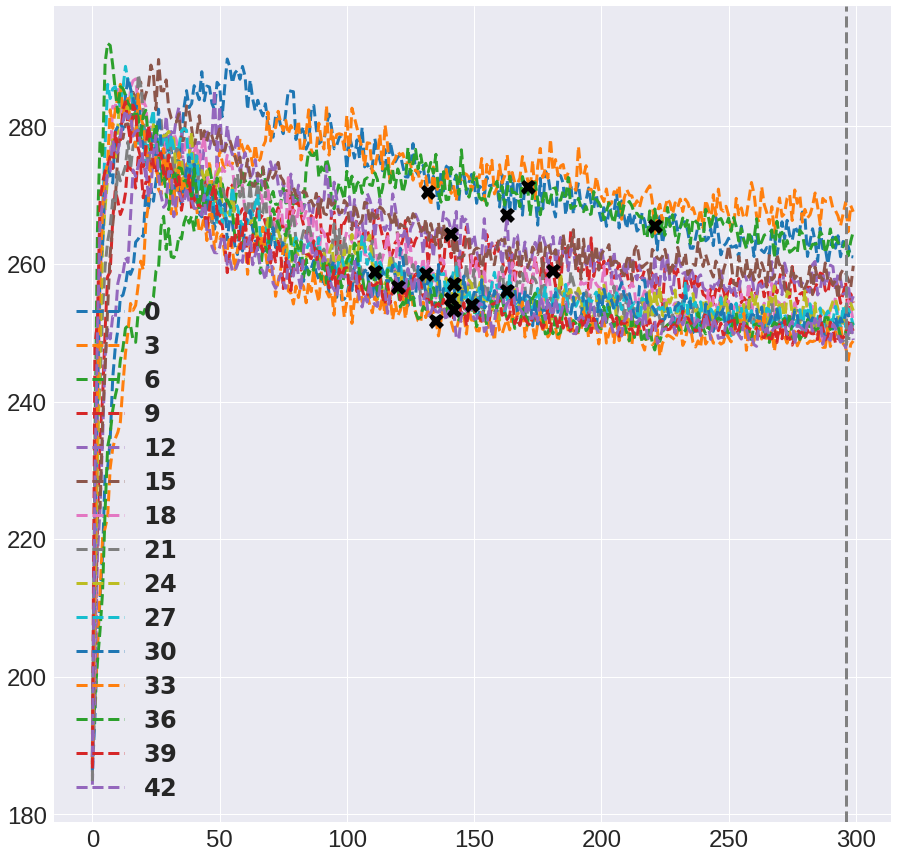

In [101]:
plot_parameter_comparison(UNSGAIII_data_10pop,"fuel_consumption")

# IBEA

In [30]:
IBEA_data = remove_unwanted_mutation_parameter_groups(IBEA_data)
add_final_fitness_columns(IBEA_data)
expand_parameter_colums(IBEA_data)
IBEA_data_10pop, IBEA_data_20pop, IBEA_data_30pop = get_population_size_splits(IBEA_data)

In [31]:
IBEA_optimal_params = IBEA_data.groupby(by=["Parameter Group"]).mean().sort_values(by=["fuel_consumption_final","longest_route_time_final"]).head(1)
IBEA_optimal_params

,Unnamed: 0,fuel_consumption_final,longest_route_time_final,mutation,crossover,population_size
Parameter Group,,,,,,
56.0,14.5,75.947418,185.996111,0.7,0.25,30.0


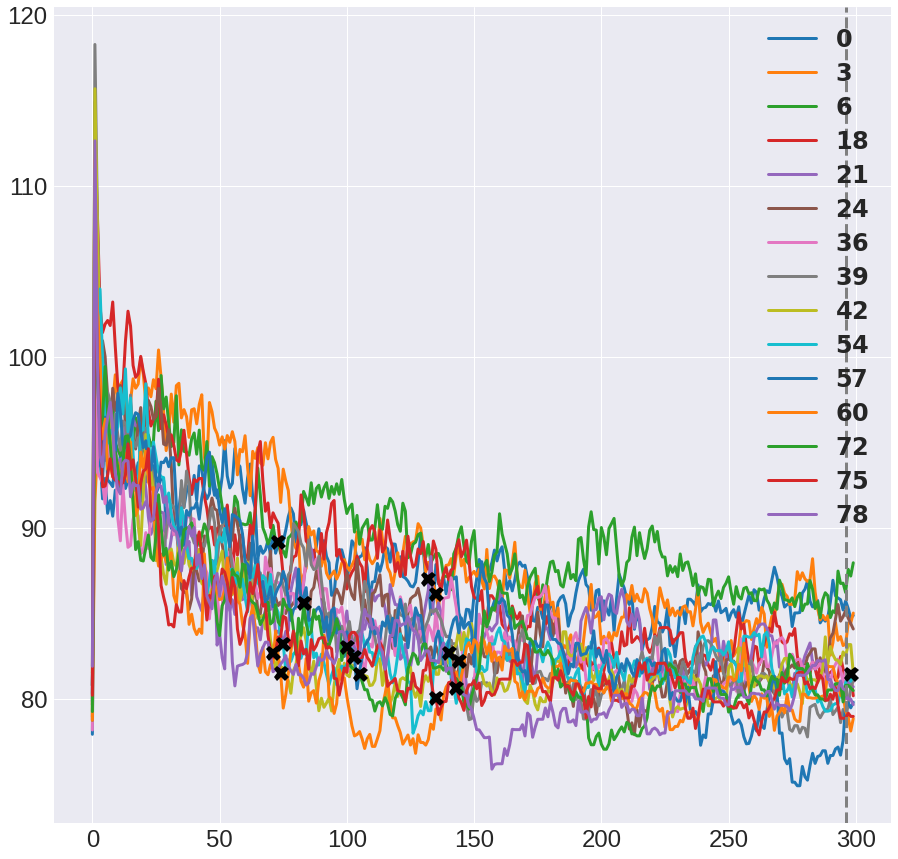

In [32]:
plot_parameter_comparison(IBEA_data_10pop,"fuel_consumption")

# Compare algorithms

In [33]:
SA_optimal_params.iloc[0].name

6.0

In [110]:
SA_optimal_params_logs = SA_data.where(SA_data["Parameter Group"] == SA_optimal_params.iloc[0].name).dropna()
SA_optimal_params_logs["Algorithm"] = "SA"
SA_fuel_consumption = np.mean(np.stack(SA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

GA_optimal_params_logs = GA_data.where(GA_data["Parameter Group"] == GA_optimal_params.iloc[0].name).dropna()
GA_optimal_params_logs["Algorithm"] = "GA"
GA_fuel_consumption = np.mean(np.stack(GA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

NSGA2_optimal_params_logs = NSGA2_data.where(NSGA2_data["Parameter Group"] == NSGA2_optimal_params.iloc[0].name).dropna()
NSGA2_optimal_params_logs["Algorithm"] = "NSGA2"
NSGA2_fuel_consumption = np.mean(np.stack(NSGA2_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

NSGA3_optimal_params_logs = NSGA3_data.where(NSGA3_data["Parameter Group"] == NSGA3_optimal_params.iloc[0].name).dropna()
NSGA3_optimal_params_logs["Algorithm"] = "NSGA3"
NSGA3_fuel_consumption = np.mean(np.stack(NSGA3_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

UNSGA3_optimal_params_logs = UNSGA3_data.where(UNSGA3_data["Parameter Group"] == UNSGA3_optimal_params.iloc[0].name).dropna()
UNSGA3_optimal_params_logs["Algorithm"] = "UNSGA3"
UNSGA3_fuel_consumption = np.mean(np.stack(UNSGA3_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

# IBEA_optimal_params_logs = IBEA_data.where(IBEA_data["Parameter Group"] == IBEA_optimal_params.iloc[0].name).dropna()
# IBEA_optimal_params_logs["Algorithm"] = "IBEA"
# IBEA_fuel_consumption = np.mean(np.stack(IBEA_optimal_params_logs.fuel_consumption.to_numpy()),axis=0)

In [111]:
min_length= []

In [113]:
curves= np.array([SA_fuel_consumption,
        GA_fuel_consumption,
        NSGA2_fuel_consumption,
        NSGA3_fuel_consumption,
        UNSGA3_fuel_consumption])#,
        #IBEA_fuel_consumption])

min_length= min([len(x) for x in curves])

for index,curve in enumerate(curves):
    if len(curve) > min_length:
        print(len(curve)/min_length)
        curves[index] = curve[::int(len(curve)/min_length)]
        #print(len(curve)/min_length)

curves = np.stack(curves,axis=0)
lables = ["SA","GA","NSGAII","NSGAIII","UNSGAIII"]


plot_conv_curves(curves,lables)

3.0
1.5
1.5
1.5


<ipython-input-113-1bf36a75fffc>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



ValueError: all input arrays must have the same shape

AttributeError: 'DataFrame' object has no attribute 'optimal_time'

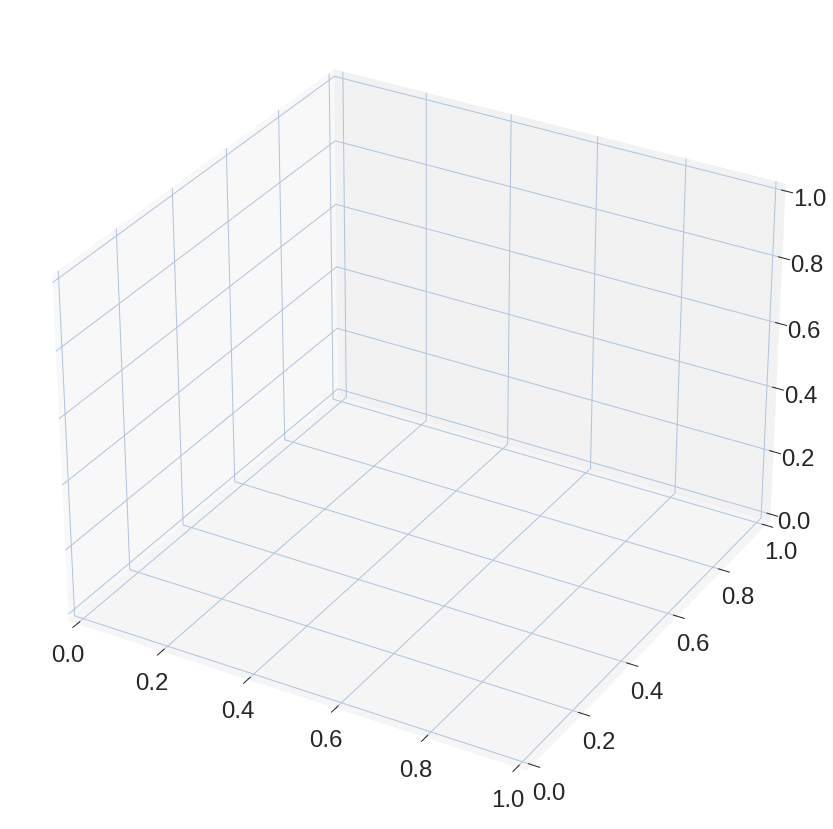

In [37]:
plot_3d([SA_optimal_params_logs,GA_optimal_params_logs],time_matrix_here)

In [70]:
GA_optimal_params_logs.fuel_consumption.head(1)

1800    [116.22755523161564, 95.68113534840995, 106.41...
Name: fuel_consumption, dtype: object

In [74]:
GA_1_percentage_time = find_fithess_within_percentage(np.stack(GA_optimal_params_logs.fuel_consumption.to_numpy(),axis=0),0.01)

In [75]:
GA_optimal_params_logs.computation_times

1800    [0.008674144744873047, 0.020137786865234375, 0...
1801    [0.009062767028808594, 0.01843714714050293, 0....
1802    [0.009242057800292969, 0.019710779190063477, 0...
1803    [0.00995326042175293, 0.020070552825927734, 0....
1804    [0.008753776550292969, 0.018940210342407227, 0...
1805    [0.00899052619934082, 0.0196382999420166, 0.02...
1806    [0.008962631225585938, 0.018410682678222656, 0...
1807    [0.009365558624267578, 0.018440723419189453, 0...
1808    [0.009392261505126953, 0.019451141357421875, 0...
1809    [0.009788274765014648, 0.0206143856048584, 0.0...
1810    [0.009740591049194336, 0.02093362808227539, 0....
1811    [0.009205818176269531, 0.019695043563842773, 0...
1812    [0.009681940078735352, 0.019551992416381836, 0...
1813    [0.008774518966674805, 0.019550323486328125, 0...
1814    [0.009433269500732422, 0.019978046417236328, 0...
1815    [0.008939504623413086, 0.0189058780670166, 0.0...
1816    [0.008556127548217773, 0.018828392028808594, 0...
1817    [0.009

In [67]:
np.mean(np.stack(GA_optimal_params_logs.computation_times.apply(literal_eval).to_numpy()),axis=0)[54]

0.5027070681254069

In [39]:
GA_optimal_params_logs["optimal_time"] = GA_optimal_params_logs

1800     92.119479
1801     82.682144
1802     84.891434
1803     82.475267
1804     81.550250
1805     87.587171
1806     94.628602
1807     93.545036
1808     83.903002
1809     92.949884
1810     90.809745
1811     79.239848
1812     75.878397
1813     79.162032
1814     88.083744
1815     85.175722
1816     88.005464
1817     91.582213
1818     83.026659
1819     80.619861
1820     89.061995
1821     81.679265
1822     86.915510
1823     96.556076
1824     85.389740
1825     94.214777
1826     86.461435
1827    103.916332
1828     79.162032
1829     79.046255
Name: fuel_consumption_final, dtype: float64